Question 1A:

In [63]:
import pandas as pd
import numpy as np


file_path = "DailyPrices.csv"
df = pd.read_csv(file_path)
df_selected = df[['SPY', 'AAPL', 'EQIX']]


arithmetic_returns = df_selected.pct_change().dropna()
arithmetic_returns -= arithmetic_returns.mean()
arithmetic_std = arithmetic_returns.std()


print("Last 5 rows of Arithmetic Returns:")
print(arithmetic_returns.tail())
print("Standard Deviation of Arithmetic Returns:")
print(arithmetic_std)
arithmetic_total_std = arithmetic_std.sum()
print("Total Arithmetic Standard Deviation:")
print(arithmetic_total_std)

Last 5 rows of Arithmetic Returns:
          SPY      AAPL      EQIX
499 -0.011492 -0.014678 -0.006966
500 -0.012377 -0.014699 -0.008064
501 -0.004603 -0.008493  0.006512
502 -0.003422 -0.027671  0.000497
503  0.011538 -0.003445  0.015745
Standard Deviation of Arithmetic Returns:
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64
Total Arithmetic Standard Deviation:
0.03692020042548768


Question 1B:

In [64]:
log_returns = np.log(df_selected / df_selected.shift(1)).dropna()
log_returns -= log_returns.mean()
log_std = log_returns.std()
print("\nLast 5 rows of Log Returns:")
print(log_returns.tail())
print("\nStandard Deviation of Log Returns:")
print(log_std)
log_total_std = log_std.sum()
print("Total Log Standard Deviation:")
print(log_total_std)


Last 5 rows of Log Returns:
          SPY      AAPL      EQIX
499 -0.011515 -0.014675 -0.006867
500 -0.012410 -0.014696 -0.007972
501 -0.004577 -0.008427  0.006602
502 -0.003392 -0.027930  0.000613
503  0.011494 -0.003356  0.015725

Standard Deviation of Log Returns:
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64
Total Log Standard Deviation:
0.036794890604909536


Question 2A: 

In [65]:
import pandas as pd


file_path = "DailyPrices.csv"
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"])
target_date = pd.Timestamp("2025-01-03")
df_target = df[df["Date"] == target_date]
holdings = {'SPY': 100, 'AAPL': 200, 'EQIX': 150}

spy_price = df_target["SPY"].values[0]
aapl_price = df_target["AAPL"].values[0]
eqix_price = df_target["EQIX"].values[0]
portfolio_value = (100 * spy_price) + (200 * aapl_price) + (150 * eqix_price)
prices_latest = df_target[['SPY', 'AAPL', 'EQIX']].values.flatten()


print("Portfolio Value on 1/3/2025:", portfolio_value)

Portfolio Value on 1/3/2025: 251862.4969482422


Question 2B: 

a: 

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import norm


df_subset = df[['Date', 'SPY', 'AAPL', 'EQIX']].copy()
df_subset.sort_values('Date', inplace=True)
df_subset.set_index("Date", inplace=True)


df_ret = df_subset / df_subset.shift(1) - 1.0
df_ret.dropna(inplace=True)


df_ret_zm = df_ret - df_ret.mean(axis=0)


def calculate_ewcov(returns, lambda_param):
    ewma_cov = returns.ewm(span=(2 / (1 - lambda_param)) - 1).cov(pairwise=True).dropna()
    return ewma_cov.iloc[-3:]  


lambda_param = 0.97
ew_cov_df = calculate_ewcov(df_ret_zm, lambda_param)
ew_cov = ew_cov_df.values


asset_vals = np.array([holdings[ticker] * prices_latest[i] for i, ticker in enumerate(holdings.keys())])
w_dollar = asset_vals / portfolio_value


port_var = w_dollar @ ew_cov @ w_dollar
port_std = np.sqrt(port_var)


alpha = 0.05
z05 = norm.ppf(alpha)
pdf_z05 = norm.pdf(z05)

var_normal = -z05 * port_std * portfolio_value
es_normal = port_std * (pdf_z05 / alpha) * portfolio_value

print("VaR (Normal Distribution with EWMA):", var_normal)
print("ES (Normal Distribution with EWMA):", es_normal)

VaR (Normal Distribution with EWMA): 3886.0208201553028
ES (Normal Distribution with EWMA): 4873.22688452894


b: 

In [67]:
import numpy as np
import pandas as pd
import scipy.stats as st


file_path = "DailyPrices.csv" 
df = pd.read_csv(file_path, parse_dates=["Date"])


def method_2b_t_copula(df_prices, selected_stocks, shares_dict, alpha=0.05):
    df_prices.sort_values("Date", inplace=True, ignore_index=True)
    df_ret = df_prices.copy()


    for stk in selected_stocks:
        df_ret[stk] = df_ret[stk].pct_change()
    df_ret.dropna(inplace=True)


    arithmetic_return_remove_mean = {stk: df_ret[stk].values - np.mean(df_ret[stk].values) for stk in selected_stocks}


    t_params = {}
    for stk in selected_stocks:
        data = arithmetic_return_remove_mean[stk]
        df_, loc_, scale_ = st.t.fit(data, method="MLE")
        t_params[stk] = (df_, loc_, scale_)


    U = pd.DataFrame({stk: st.t.cdf(arithmetic_return_remove_mean[stk], *t_params[stk]) for stk in selected_stocks})


    Z = U.apply(lambda x: st.norm.ppf(x))


    R_spearman = Z.corr(method='spearman')

    n_samples = 10000
    np.random.seed(42)
    copula_sim = st.multivariate_normal.rvs(
        mean=np.zeros(len(selected_stocks)),
        cov=R_spearman,
        size=n_samples
    )


    sim_returns_t = np.zeros_like(copula_sim)
    for i, stk in enumerate(selected_stocks):
        df_, loc_, scale_ = t_params[stk]
        sim_u = st.norm.cdf(copula_sim[:, i])
        sim_returns_t[:, i] = st.t.ppf(sim_u, df_, loc_, scale_)


    latest_row = df_prices.iloc[-1]
    sim_pnl_t = np.zeros(n_samples)
    for i, stk in enumerate(selected_stocks):
        n_shares = shares_dict[stk]
        price_now = latest_row[stk]
        sim_pnl_t += n_shares * price_now * sim_returns_t[:, i]


    var_5 = np.percentile(sim_pnl_t, alpha * 100)
    tail_mask = (sim_pnl_t <= var_5)
    es_5 = sim_pnl_t[tail_mask].mean() if np.any(tail_mask) else var_5


    return var_5, es_5, sim_pnl_t


var_5, es_5, sim_pnl_t = method_2b_t_copula(
    df, 
    ["SPY", "AAPL", "EQIX"], 
    {"SPY": 100, "AAPL": 200, "EQIX": 150}, 
    alpha=0.05
)

print("VaR (T-Copula):", -var_5)
print("ES (T-Copula):", -es_5)

VaR (T-Copula): 4390.50178064816
ES (T-Copula): 6139.692091019668


c: 

In [68]:
import pandas as pd
import numpy as np
from scipy.stats import norm


df_prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"])
df_prices.sort_values("Date", inplace=True)


holdings = {
    "SPY":  100.0,
    "AAPL": 200.0,
    "EQIX": 150.0
}

today_str = "2025-01-03"
row_today = df_prices.loc[df_prices["Date"] == today_str]


prices_today = {}
for ticker in holdings.keys():
    prices_today[ticker] = float(row_today[ticker].values[0])


alpha = 0.05
tickers_used = list(holdings.keys())


pl_hist = df_ret_zm.values @ np.array([
    holdings[t] * prices_today[t] for t in tickers_used
])


var_hist = np.percentile(pl_hist, alpha * 100)  
es_hist = pl_hist[pl_hist <= var_hist].mean() if np.any(pl_hist <= var_hist) else var_hist


print("VaR (Historical Simulation): ",-var_hist)
print("ES (Historical Simulation): ",-es_hist)

VaR (Historical Simulation):  4575.0340603897785
ES (Historical Simulation):  6059.3870757686855


Problem 3A: 

In [69]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq


S = 31  
X = 30  
T = 0.25  
r = 0.10  
C_market = 3.00  


def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def implied_volatility(C_market, S, X, T, r):
    try:
        return brentq(lambda sigma: black_scholes_call(S, X, T, r, sigma) - C_market, 0.01, 2.0)
    except ValueError:
        return None


sigma_iv = implied_volatility(C_market, S, X, T, r)


print(f"Implied Volatility is {sigma_iv}")

Implied Volatility is 0.33508039247879023


Question 3B: 

In [70]:
if sigma_iv:
    d1 = (np.log(S / X) + (r + 0.5 * sigma_iv**2) * T) / (sigma_iv * np.sqrt(T))
    d2 = d1 - sigma_iv * np.sqrt(T)

    delta = norm.cdf(d1)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta = (- (S * norm.pdf(d1) * sigma_iv) / (2 * np.sqrt(T))) - (r * X * np.exp(-r * T) * norm.cdf(d2))

    option_price_change = vega * 0.01

    results = {
        "Implied Volatility": sigma_iv,
        "Delta": delta,
        "Vega": vega,
        "Theta": theta,
        "Option Price Change for 1% Vol Increase": option_price_change,
    }
else:
    results = {"Error": "Could not find implied volatility."}
    
import pandas as pd
df = pd.DataFrame(results, index=[0])
df

sigma_new = sigma_iv + 0.01

C_new = black_scholes_call(S, X, T, r, sigma_new)

delta_C_actual = C_new - C_market

proof_results = pd.DataFrame({
    "Metric": ["Original Call Price", "New Call Price (1% Vol Increase)", "Actual Change in Call Price", "Estimated Change (Vega Method)", "Difference"],
    "Value": [C_market, C_new, delta_C_actual, option_price_change, delta_C_actual - option_price_change]
})
print("Delta value:", delta)
print("Vega value:", vega)
print("Theta value:", theta)
proof_results

Delta value: 0.6659296527386922
Vega value: 5.640705439230116
Theta value: -5.544561508358894


,Metric,Value
0,Original Call Price,3.000000
1,New Call Price (1% Vol Increase),3.056498
2,Actual Change in Call Price,0.056498
3,Estimated Change (Vega Method),0.056407
4,Difference,0.000091


In [71]:
def black_scholes_put(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return X * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


rhs = black_scholes_put(S, X, T, r, sigma_iv) + S
lhs = C_market + X * np.exp(-r * T)
difference = lhs - rhs
print("C + PV(X):", lhs)
print("P + S:", rhs)
print("Difference:", difference)

C + PV(X): 32.25929736084998
P + S: 32.25929736084998
Difference: 0.0


Question 3D: 

In [72]:
import math
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq

def call_price_bs(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    # b = r => e^{(b-r)T} = e^0 = 1
    C = S * norm.cdf(d1) - X * exp(-r*T) * norm.cdf(d2)
    return C

def put_price_bs(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    P = X * exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return P

def implied_vol_bs(S, X, T, r, market_price):
    def objective(sigma):
        return call_price_bs(S, X, T, r, sigma) - market_price
    vol_lower, vol_upper = 1e-6, 5.0
    return brentq(objective, vol_lower, vol_upper)

def call_delta(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return norm.cdf(d1)

def put_delta(S, X, T, r, sigma):
    d1 = (np.log(S/X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1

def call_vega(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S * norm.pdf(d1) * sqrt(T)

def call_theta(S, X, T, r, sigma):
    d1 = (log(S/X) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    term1 = - (S * norm.pdf(d1) * sigma) / (2.0 * sqrt(T))
    term2 = - r * X * exp(-r*T) * norm.cdf(d2)
    return term1 + term2

def put_theta(S, X, T, r, sigma):
    d1 = (np.log(S/X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    term1 = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    term2 = r * X * np.exp(-r * T) * norm.cdf(-d2)
    return term1 + term2


S = 31.0      
X = 30.0      
r = 0.10    
T = 0.25     
call_market_price = 3.0 
trading_days_per_year = 255
holding_days = 20  
alpha = 0.05      
stock_annual_vol = 0.25 


call_ini = call_price_bs(S, X, T, r, sigma_iv)
put_ini  = put_price_bs(S, X, T, r, sigma_iv)
portfolio_ini = call_ini + put_ini + S


print("Portfolio Info")
print(f"Stock Price       = {S:.2f}")
print(f"Call Price        = {call_ini:.2f}")
print(f"Put  Price        = {put_ini:.2f}")
print(f"Initial Portfolio = {portfolio_ini:.2f}")

Portfolio Info
Stock Price       = 31.00
Call Price        = 3.00
Put  Price        = 1.26
Initial Portfolio = 35.26


In [73]:
sigma_daily = stock_annual_vol / math.sqrt(trading_days_per_year)
sigma_20days = sigma_daily * math.sqrt(holding_days)


call_market_price = 3.0  
sigma_iv = implied_vol_bs(S, X, T, r, call_market_price)



delta_call = call_delta(S, X, T, r, sigma_iv)
delta_put  = put_delta(S, X, T, r, sigma_iv)
delta_stock= 1.0
portfolio_delta = delta_call + delta_put + delta_stock


theta_call = call_theta(S, X, T, r, sigma_iv)
theta_put = put_theta(S, X, T, r, sigma_iv)  
portfolio_theta = theta_call + theta_put  


dt = holding_days / trading_days_per_year
mean_pnl = portfolio_theta * dt  


std_dev_pnl = abs(portfolio_delta) * S * sigma_20days 


z_alpha = norm.ppf(alpha)
var_delta_normal = -(mean_pnl + z_alpha * std_dev_pnl)


phi_z = norm.pdf(z_alpha)
es_delta_normal = - (std_dev_pnl * phi_z / alpha + mean_pnl)

print("Delta-Normal Approximation")
print(f"Portfolio Delta = {portfolio_delta:.4f}")
print(f"Portfolio Theta = {portfolio_theta:.4f}")
print(f"Mean of 20d PnL = {mean_pnl:.4f}")
print(f"Std of 20d PnL  = {std_dev_pnl:.4f}")
print(f"VaR  (95%)      = {var_delta_normal:.4f}")
print(f"ES   (95%)      = {es_delta_normal:.4f}")

Delta-Normal Approximation
Portfolio Delta = 1.3319
Portfolio Theta = -8.1632
Mean of 20d PnL = -0.6403
Std of 20d PnL  = 2.8907
VaR  (95%)      = 5.3951
ES   (95%)      = -5.3225


In [74]:
n_sims = 100000
np.random.seed(42)

mean_return = 0  
random_returns = np.random.normal(mean_return, sigma_20days, n_sims)
simulated_stock_prices = S * np.exp(random_returns)

time_to_maturity_updated = T - (holding_days / trading_days_per_year)
call_option_values_simulated = [black_scholes_call(s_i, X, time_to_maturity_updated, r, sigma_iv) for s_i in simulated_stock_prices]
put_option_values_simulated = [black_scholes_put(s_i, X, time_to_maturity_updated, r, sigma_iv)  for s_i in simulated_stock_prices]

portfolio_20days = np.array(call_option_values_simulated) + np.array(put_option_values_simulated) + simulated_stock_prices
portfolio_0 = portfolio_ini
profit_and_loss = portfolio_20days - portfolio_0

pnl_sorted = np.sort(profit_and_loss)
var_index = int(alpha * n_sims)
var_mc = -pnl_sorted[var_index]
es_mc = -pnl_sorted[:var_index].mean()

print("Monte Carlo Simulation")
print(f"Number of sims = {n_sims}")
print(f"Mean of PnL    = {profit_and_loss.mean():.4f}")
print(f"VaR  (95%)     = {var_mc:.4f}")
print(f"ES   (95%)     = {es_mc:.4f}")

Monte Carlo Simulation
Number of sims = 100000
Mean of PnL    = -0.2166
VaR  (95%)     = 4.1277
ES   (95%)     = 4.5761


Question 3E:

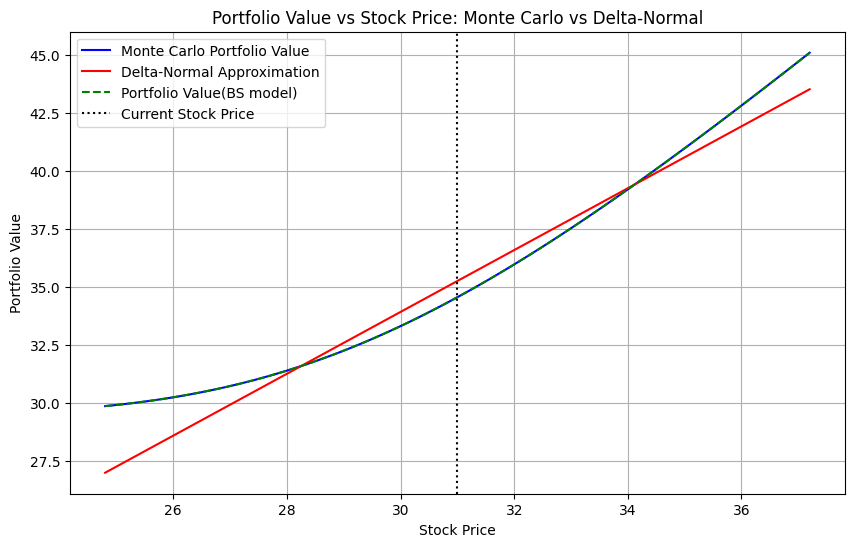

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt


S_sims = np.linspace(S * 0.8, S * 1.2, 100)  
T_new = T - (holding_days / trading_days_per_year)
call_value_true = np.array([black_scholes_call(s, X, T_new, r, sigma_iv) for s in S_sims])
put_value_true = np.array([black_scholes_put(s, X, T_new, r, sigma_iv) for s in S_sims])
portfolio_BS = call_value_true + put_value_true + S_sims 

call_values = np.array([black_scholes_call(s_i, X, T_new, r, sigma_iv) for s_i in S_sims])
put_values = np.array([black_scholes_put(s_i, X, T_new, r, sigma_iv) for s_i in S_sims])
portfolio_mc = call_values + put_values + S_sims


portfolio_delta_normal = portfolio_0 + portfolio_delta * (S_sims - S)


plt.figure(figsize=(10, 6))
sns.lineplot(x=S_sims, y=portfolio_mc, label="Monte Carlo Portfolio Value", color="blue")
sns.lineplot(x=S_sims, y=portfolio_delta_normal, label="Delta-Normal Approximation", color="red")
sns.lineplot(x=S_sims, y=portfolio_BS, label="Portfolio Value(BS model)", color="green", linestyle="dashed")
plt.axvline(S, color="black", linestyle="dotted", label="Current Stock Price")
plt.xlabel("Stock Price")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value vs Stock Price: Monte Carlo vs Delta-Normal")
plt.legend()
plt.grid(True)
plt.show()